<a href="https://colab.research.google.com/github/jacquelynblum/jblum/blob/master/HW4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 4 Problem 2: Transfer learning with the MobileNets**

## Instruction:
Submit your homework by publishing a notebook that cleanly displays your code, results, and plots to pdf or html. Also, be sure to answer all the reflection questions.

**For coding questions, look for filling in ########## Your code here ##########; for reflection questions, write down your answers in the "Your Answer:" text block.**

## Description:
In this homework, you will practice (1) going over the full procedure of training a neural network and (2) extending your knowledge on TF2, by implementing a transfer learning task. You will incorporate the existing [MobileNets](https://arxiv.org/abs/1704.04861) to your own network structure and to classify some new categories of images. Building and fitting the network from scratch is expensive and beyond the scope of this assignment, so you will load the MobileNets model which was pre-trained on the imagenet dataset. The version of MobileNet we're using is V2, which is a family of neural network architectures for efficient on-device image classification and related tasks.

As a general advice, please refer to the official documentations for more info in necessary: [Keras](https://keras.io/), [TF Datasets](https://www.tensorflow.org/datasets), and [TF Hub](https://www.tensorflow.org/hub).

**First, let's not forget to upgrade to TF 2.0.**



In [1]:
#!pip install --upgrade tensorflow

**Import modules for later usage.**

In [2]:
import tensorflow as tf

#from tensorflow import keras 
!pip install -q tensorflow tensorflow-datasets matplotlib tensorflow_hub
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_hub as hub

print("TF version: ",tf.__version__)
print("Keras version:",tf.keras.__version__)

TF version:  2.3.0
Keras version: 2.4.0


## **Part 1: Download and format the data**

The data we are going to use is the [Oxford flower dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/) which consists of 102 categories of flowers. Each class consists of between 40 and 258 images. The images can be found [here](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html).

The main difficulty of learninig from this dataset is in the large size of the classes. You may refer to [this paper](http://www.robots.ox.ac.uk/~vgg/publications/2008/Nilsback08/) for what other researchers have done with it.

### (1) Data Pre-processing

First, load the dataset from [Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/overview) and split the data into training and testing sets. How many training and testing samples do you have? Save the numbers to two variables, *num_train* and *num_test*, respectively.

In [3]:
(train_data, test_data), info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True, split = ['train', 'test'])

In [4]:
info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=8

In [5]:
# Print the number of training and testing samples

num_train = train_data.cardinality().numpy()
num_test = test_data.cardinality().numpy()

num_train
num_test


6149

Next, we would like to format all the images for the MobileNet module. 

For this module, the size of the input image is fixed to height x width = 224 x 224 pixels. The input images are expected to have 3 RGB color values in the range [0, 1], following the common image input conventions (analogously to TF 1.x).

In [6]:
# Initiate the parameters
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [7]:
# Define a function to format the data 
@tf.function
def format_example(image, label):
    print("Format example called!")
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [8]:
# Apply the above function to the previous train_data and test_data,
# to get the formatted training and testing sets, respectively.

train = train_data.map(format_example)
test = test_data.map(format_example)


Format example called!


### (2) Data Exploration

Let's plot some of the data.

In [9]:
assert isinstance(train, tf.data.Dataset)
assert isinstance(test, tf.data.Dataset)
print(train)
print(test)

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


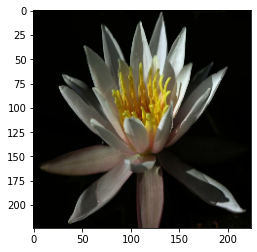

Label: 72


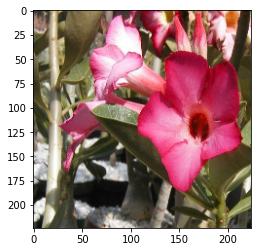

Label: 84


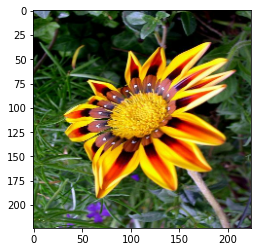

Label: 70


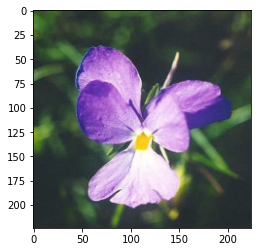

Label: 51


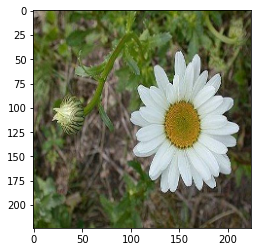

Label: 48


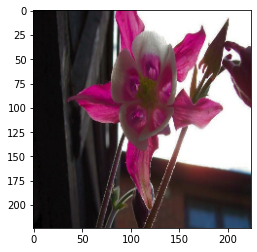

Label: 83


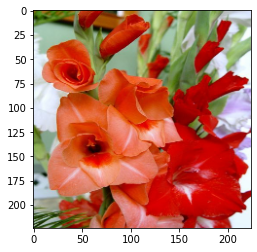

Label: 42


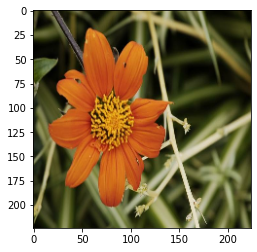

Label: 58


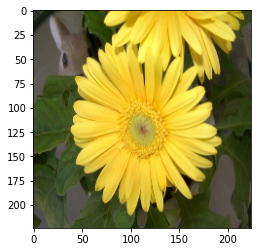

Label: 40


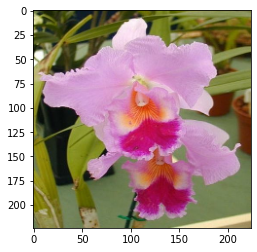

Label: 35


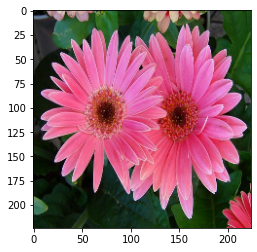

Label: 40


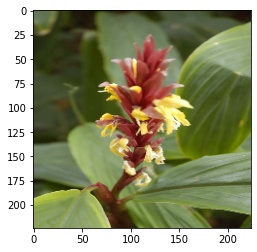

Label: 60


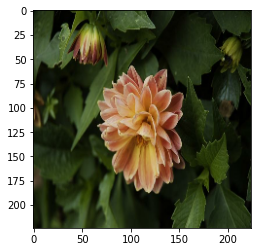

Label: 59


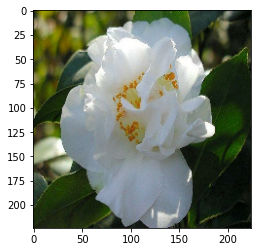

Label: 95


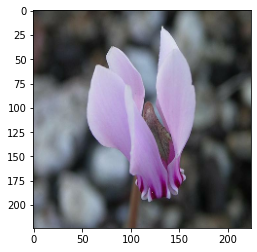

Label: 87


In [10]:
for example in train.take(15):  # Take first 15 examples
  image, label = example[0], example[1]
  plt.imshow(image.numpy())
  plt.pause(0.5);
  print("Label: %d" % label.numpy())

### **Reflection Questions:**
(1) In the data exploration stage, what is the purpose of "***assert isinstance(train, tf.data.Dataset)***"?

**Your Answer:** 



## **Part 2: Self-defined CNN** 

In this section, you will define your own CNN to classify the Oxford flowers. 

Recall from the tutorial, to build a neural network using tf.keras, there are three steps: defining the model, compiling the model and fitting the model. Each step should be straightforward. 

After fitting the model, visualize your model in TensorBoard.

In this stage, we do not ask for a good performance. But please ensure that you obtain a trainable model with no programming bugs.

In [11]:
# Step 1: Model definition
# Use a Keras Sequential model for defining your own CNN
from tensorflow import keras
%load_ext tensorboard

import datetime, os
from packaging import version
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(300, activation='relu'), 
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(102, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 300)               45158700  
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 102)               10302     
Total params: 45,199,102
Trainable params: 45,199,102
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Step 2: Model compilation
# Be sure to specify the optimizer, loss and metric as required

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.01, nesterov=True),
              metrics=["accuracy"])


In [13]:
# Step 3: Model fitting
# Use the prepared training data to fit your CNN

model.fit(train.shuffle(10000).batch(32), epochs=5)

Epoch 1/5
32/32 [==============================] - 1s 18ms/step - loss: 4.7622 - accuracy: 0.0069
Epoch 2/5
32/32 [==============================] - 1s 19ms/step - loss: 4.6363 - accuracy: 0.0108
Epoch 3/5
32/32 [==============================] - 1s 19ms/step - loss: 4.6118 - accuracy: 0.0225
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 4.5909 - accuracy: 0.0235
Epoch 5/5
32/32 [==============================] - 1s 19ms/step - loss: 4.5536 - accuracy: 0.0294


### **Reflection Questions:**

(1) How did you choose your network structure? \\
(2) Which optimizer did you use? Why? \\

**Your Answer:** 

1) I chose my network structure because this is what they use in the Geron textbook for the MNIST dataset. I used the softmax activation function because the classes are exclusive.

2) I used stochastic gradient descent with nesterov=True because it's a good combination of speed and quality. 

## **Part 3: Transfer Learning Using Pre-trained Model**

For more info about transfer learning, please look up [here](http://ronny.rest/blog/post_2017_10_13_tf_transfer_learning/). In this homework, you will practice B2, using MobileNet_V2.

### (1) Transfer learning using pre-defined features (bottleneck). 

In [14]:
import tensorflow as tf
MobileNet = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [15]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("oxford_flowers102", as_supervised=True, with_info=True)
dataset_size=info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"]

In [16]:
info.splits["train"]

dataset_size = info.splits["train"].num_examples
dataset_size

1020

In [17]:

test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "oxford_flowers102",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True, shuffle_files=True)

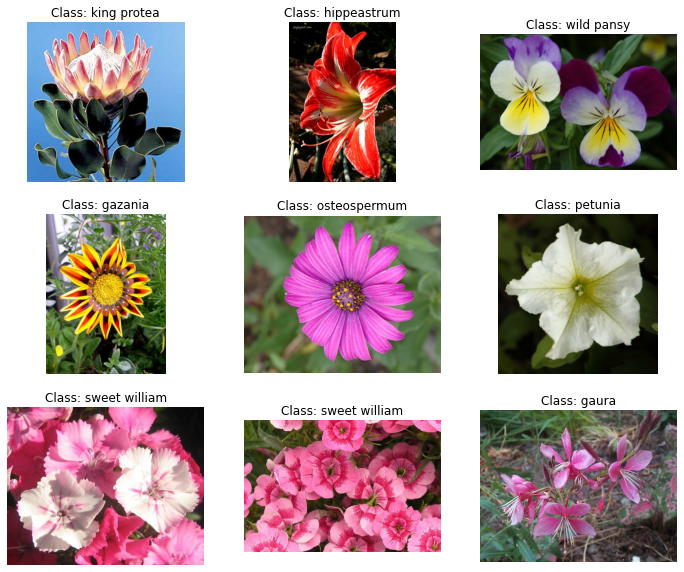

In [18]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [19]:

from keras.applications.mobilenet_v2 import preprocess_input


def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.MobileNetV2.preprocess_input(resized_image)
    return final_image, label

def format_example(image, label):
    print("Format example called!")
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [20]:
from functools import partial
from tensorflow import keras


batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(format_example).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(format_example).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(format_example).batch(batch_size).prefetch(1)

Format example called!
Format example called!
Format example called!


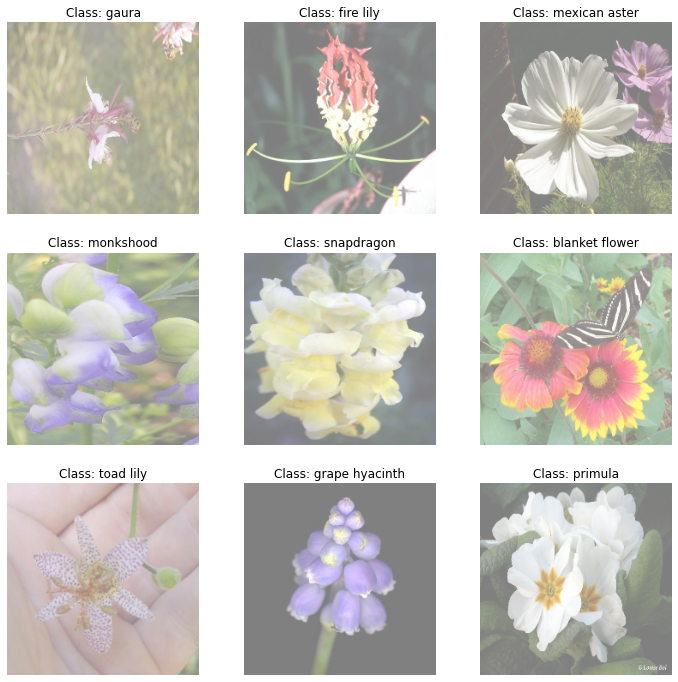

In [21]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [22]:


MobileNet = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [23]:
print(n_classes)

ClassLabel(shape=(), dtype=tf.int64, num_classes=102)


In [24]:
avg = keras.layers.GlobalAveragePooling2D()(MobileNet.output)
output = keras.layers.Dense(102, activation="softmax")(avg)
model = keras.models.Model(inputs=MobileNet.input, outputs=output)

In [ ]:

for index, layer in enumerate(MobileNet.layers):
    print(index, layer.name)

In [ ]:
# visualize the model graphical structure
model.summary()

In [27]:
# This block is for Tensorboard

# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime, os
from packaging import version

# Clear any logs from previous runs
!rm -rf ./logs/ 

# For use of Tensorboard later
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [28]:
# Step 2: Model compilation
# Be sure to specify the optimizer, loss and metric as required

for layer in MobileNet.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
# Step 3: Model fitting
# Use the prepared training data to fit the transfer learning model

history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40,
                    callbacks=[tf.keras.callbacks.TensorBoard(log_dir=logs_base_dir, histogram_freq=1)])

In [39]:
# Step 4: Model evaluation
# Use the prepared testing data to evaluate the transfer learning model

results = model.evaluate(test_set)
results

4/4 [==============================] - 0s 56ms/step - loss: 1.5173 - accuracy: 0.7059


[1.517295479774475, 0.7058823704719543]

Now you can go through the same steps to build and train the transfer learning model.

### (2) Look at the network architecture and performance evolution in tensorboard. 

In [278]:
# Refresh TensorBoard
%reload_ext tensorboard


### (3) Fine-tune some parameters in your network to see if you can improve the performance on testing data.

When I unfreeze all the layers, the validation accuracy drops to like 5%, so I tried a few variations and settled on unfreezing the top 15 layers. 

In [42]:
for layer in MobileNet.layers:
    layer.trainable = True

print("Number of layers in the base model: ", len(MobileNet.layers))


Number of layers in the base model:  155


In [54]:
fine_tune_at = 140
for layer in MobileNet.layers[:fine_tune_at]:
  layer.trainable =  False

In [55]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
model_ft = model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40,
                    callbacks=[tf.keras.callbacks.TensorBoard(log_dir=logs_base_dir, histogram_freq=1)])

Okay, unfreezing the top 15 layers got us to about 75% accuracy. Next I'll try adjusting the optimizer parameters.

I think a big problem is the size of the training set. I need to do more image augmentation to create a larger training corpus.

In [94]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'oxford_flowers102',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

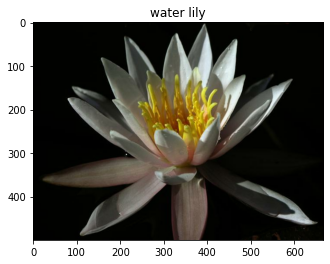

In [96]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [97]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

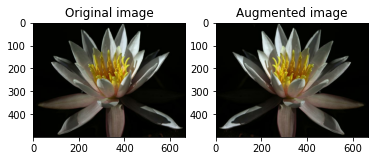

In [98]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

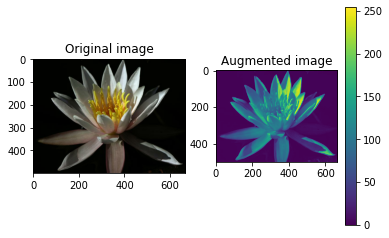

In [99]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

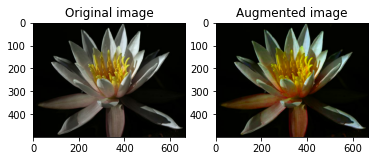

In [100]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

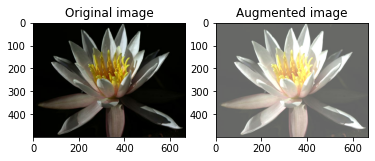

In [101]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

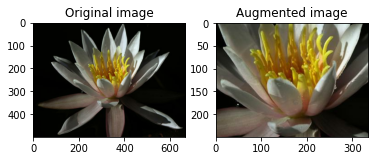

In [102]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

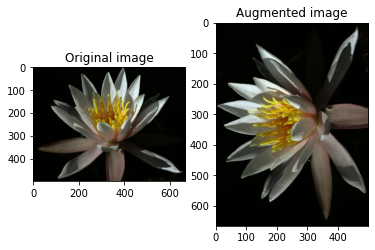

In [103]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

In [104]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [105]:
def augment(image,label):
  image, label = resize_and_rescale(image, label)
  # Add 6 pixels of padding
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
   # Random crop back to the original size
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.clip_by_value(image, 0, 1)
  return image, label

In [106]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [107]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [108]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

### **Reflection Questions:**

(1) Briefly explain the network structure of MobileNet and how is it different from other models? \\
(2) In your experiment, which parameter(s) is the network most sensitive to? Can you briefly reason why? \\
(3) What are some pros and cons of doing transfer learning? \\
(4) What is a batch? How does the batch size affect the training process? \\
(5) What is an epoch during the training process?




**Your Answer:** 

1. MobileNet uses depthwise separable convolutions. It is less computationally expensive than other models. 
2. The network was most sensitive to a change in learning rate, because it almost immediately overfitted the data if the learning rate was too high.
3. The pros of transfer learning is that you can use a smaller dataset because it is already trained, and the cons are that it is hard to do right! It's especially hard to know how many layers to unfreeze. 
4. A batch is the number of samples to work through before updating the internal model parameters.
5. An epoch is an iteration over the entire dataset. 
